In [1]:
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
from torchvision.models import vgg16
import torch
import torch.optim as optim
from collections import Counter
from sklearn.metrics import accuracy_score

In [3]:
# load dataset from Hugging Face

ds = load_dataset("Aledade/RCL-Lymphnode-Cancer-Biopsy-100K-subsampled")

Found cached dataset parquet (C:/Users/Lenovo/.cache/huggingface/datasets/Aledade___parquet/Aledade--RCL-Lymphnode-Cancer-Biopsy-100K-subsampled-7b36554b601807ae/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
class_labels = [cla['label'] for cla in ds['train']]
label_counts = Counter(class_labels)

print("Dataset Size:", len(class_labels))
print("Label Distribution:", label_counts)


Dataset Size: 400
Label Distribution: Counter({0: 360, 1: 40})


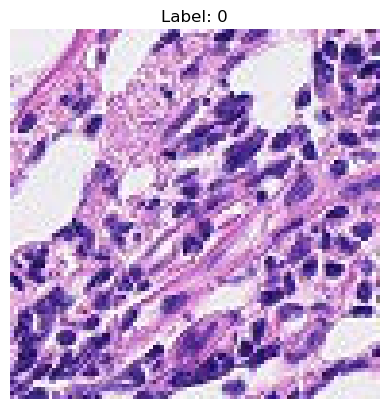

In [5]:
record = ds['train'][0]
image = record['image']  
label = record['label']  
plt.imshow(image)
plt.axis('off')  
plt.title(f"Label: {label}")
plt.show()

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]['image']
        label = self.data[idx]['label']

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
transform = Compose([
    Resize((224, 224)),  # Resize images to fit VGG16 input
    ToTensor(),          # Convert images to tensors
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

In [8]:
full_dataset = CustomImageDataset(ds['train'], transform)

In [9]:
print(ds['train'][0])

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=96x96 at 0x22239D30CD0>, 'label': 0}


In [ ]:
# Define the Custom VGG16 model
class CustomVGG16(nn.Module):
    def __init__(self, input_channels, output_dim):
        super(CustomVGG16, self).__init__()
        self.base_model = vgg16(pretrained=True)

        # Modify the first convolutional layer
        self.base_model.features[0] = nn.Conv2d(
            input_channels, 64, kernel_size=3, stride=1, padding=1
        )

        # Modify the last fully connected layer
        num_features = self.base_model.classifier[6].in_features
        self.base_model.classifier[6] = nn.Linear(num_features, output_dim)

    def forward(self, x):
        return self.base_model(x)

In [ ]:
# Define the training function
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()  
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(train_loader)

# Define the validation function
def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()  
    val_loss = 0.0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Get predicted classes
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Calculate validation accuracy
    accuracy = accuracy_score(y_true, y_pred)

    return val_loss / len(val_loader), accuracy

In [ ]:
# Training loop with early stopping
def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, device, num_epochs, patience=5):
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        # Training phase
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)

        # Validation phase
        val_loss, val_accuracy = validate_one_epoch(model, val_loader, criterion, device)

        print(f"Epoch [{epoch + 1}/{num_epochs}] | "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break


In [ ]:
# Dataset splitting and loading
def prepare_data_loaders(full_dataset, batch_size):
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size

    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

# Define a custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]['image']
        label = self.data[idx]['label']

        if self.transform:
            image = self.transform(image)

        return image, label


In [10]:
# Main execution
if __name__ == "__main__":
    # Transformations
    transform = Compose([
        Resize((224, 224)),  # Resize images to fit VGG16 input
        ToTensor(),          # Convert images to tensors
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])

 
    full_dataset = CustomImageDataset(ds['train'], transform=transform)

    # Hyperparameters
    input_channels = 3  # For RGB images
    output_dim = len(set(item['label'] for item in ds['train']))  # Number of classes
    batch_size = 32
    num_epochs = 50  
    learning_rate = 0.001  
    weight_decay = 0.01
    patience = 5  # Early stopping patience

    # Prepare data loaders
    train_loader, val_loader = prepare_data_loaders(full_dataset, batch_size)

    # Initialize the model, loss function, and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CustomVGG16(input_channels, output_dim).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Train the model with early stopping
    train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, device, num_epochs, patience)


D:\anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50] | Train Loss: 0.7403 | Val Loss: 0.4079 | Val Accuracy: 0.9125
Epoch [2/50] | Train Loss: 0.5001 | Val Loss: 0.3520 | Val Accuracy: 0.9125
Epoch [3/50] | Train Loss: 0.4032 | Val Loss: 0.3235 | Val Accuracy: 0.9125
Epoch [4/50] | Train Loss: 0.3531 | Val Loss: 0.3126 | Val Accuracy: 0.9125
Epoch [5/50] | Train Loss: 0.3283 | Val Loss: 0.4717 | Val Accuracy: 0.9125
Epoch [6/50] | Train Loss: 0.3886 | Val Loss: 0.3261 | Val Accuracy: 0.9125
Epoch [7/50] | Train Loss: 0.3548 | Val Loss: 0.3139 | Val Accuracy: 0.9125
Epoch [8/50] | Train Loss: 0.3550 | Val Loss: 0.3110 | Val Accuracy: 0.9125
Epoch [9/50] | Train Loss: 0.3665 | Val Loss: 0.3121 | Val Accuracy: 0.9125
Epoch [10/50] | Train Loss: 0.3953 | Val Loss: 0.4112 | Val Accuracy: 0.9125
Epoch [11/50] | Train Loss: 0.4038 | Val Loss: 0.4264 | Val Accuracy: 0.9125
Epoch [12/50] | Train Loss: 0.4821 | Val Loss: 0.4426 | Val Accuracy: 0.9125
Epoch [13/50] | Train Loss: 0.4216 | Val Loss: 0.3163 | Val Accuracy: 0.9125
Early st

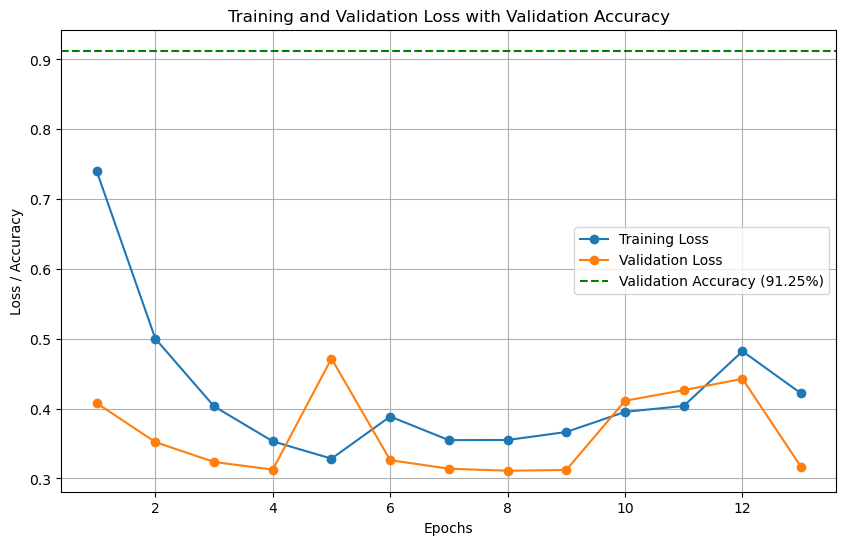

In [11]:
#data for visualization
epochs = list(range(1, 14))  
train_loss = [0.7403, 0.5001, 0.4032, 0.3531, 0.3283, 0.3886, 0.3548, 0.3550, 0.3665, 0.3953, 0.4038, 0.4821, 0.4216]
val_loss = [0.4079, 0.3520, 0.3235, 0.3126, 0.4717, 0.3261, 0.3139, 0.3110, 0.3121, 0.4112, 0.4264, 0.4426, 0.3163]
val_accuracy = [0.9125] * 13  

# Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label="Training Loss", marker='o')
plt.plot(epochs, val_loss, label="Validation Loss", marker='o')

# Adding a horizontal line for validation accuracy
plt.axhline(y=0.9125, color='green', linestyle='--', label="Validation Accuracy (91.25%)")

# Adding labels, title, and legend
plt.title("Training and Validation Loss with Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss / Accuracy")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()